In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
import itertools
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score
from sklearn.feature_selection import RFE
#import optuna

## Data Preprocessing

In [18]:
train=pd.read_csv('Train_dataset.csv')
test = pd.read_csv('Test_dataset.csv')
train=train.dropna()
test = test.dropna()

train.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


### Filtering train and test records by protocol_type column (only TCP/IP protocols)

In [19]:
print(train['protocol_type'].unique())
print(test['protocol_type'].unique())

['tcp' 'udp' 'icmp']
['tcp' 'icmp' 'udp']


In [20]:
train = train[train.protocol_type != 'udp']
test = test[test.protocol_type != 'udp']
print(train['protocol_type'].unique())
print(test['protocol_type'].unique())

['tcp' 'icmp']
['tcp' 'icmp']


### Replace value if records is anomalous due to limit class column to two value - normal and anomalous

In [21]:
print(train['class'].unique())

['normal' 'anomaly']


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22181 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22181 non-null  int64  
 1   protocol_type                22181 non-null  object 
 2   service                      22181 non-null  object 
 3   flag                         22181 non-null  object 
 4   src_bytes                    22181 non-null  int64  
 5   dst_bytes                    22181 non-null  int64  
 6   land                         22181 non-null  int64  
 7   wrong_fragment               22181 non-null  int64  
 8   urgent                       22181 non-null  int64  
 9   hot                          22181 non-null  int64  
 10  num_failed_logins            22181 non-null  int64  
 11  logged_in                    22181 non-null  int64  
 12  num_compromised              22181 non-null  int64  
 13  root_shell           

In [23]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly


In [24]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,22181.000000,2.218100e+04,2.218100e+04,22181.000000,22181.000000,22181.000000,22181.000000,22181.000000,22181.000000,22181.00000,...,22181.000000,22181.000000,22181.000000,22181.000000,22181.000000,22181.000000,22181.000000,22181.000000,22181.00000,22181.000000
mean,280.365132,2.762382e+04,3.956322e+03,0.000090,0.001623,0.000045,0.224922,0.001353,0.448357,0.25878,...,176.602678,109.733961,0.499280,0.075232,0.130660,0.035964,0.324049,0.317835,0.12844,0.134892
std,2767.643084,2.569219e+06,9.465888e+04,0.009495,0.040255,0.006714,2.294452,0.048401,0.497337,11.10159,...,101.265191,110.235593,0.451275,0.175432,0.291119,0.117120,0.461442,0.462516,0.31994,0.334957
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,69.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,1.800000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,255.000000,47.000000,0.350000,0.030000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.000000,2.970000e+02,8.200000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,...,255.000000,255.000000,1.000000,0.070000,0.050000,0.020000,1.000000,1.000000,0.00000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,1.000000,1.000000,77.000000,4.000000,1.000000,884.00000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [25]:
train.describe(include='object')

,protocol_type,service,flag,class
count,22181,22181,22181,22181
unique,2,64,11,2
top,tcp,http,SF,anomaly
freq,20526,8003,11962,11239


### Missing Data

In [26]:
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

### Duplicates

In [27]:
duplicates = train.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates != 0:
    train=train.drop_duplicates()
    print(f"Number of duplicate rows after removing them: {train.duplicated().sum()}")


Number of duplicate rows: 0


### Outliers

In [28]:
# for col in train:
#     if col != 'class' and is_numeric_dtype(train[col]):
#         fig, ax = plt.subplots(2, 1, figsize=(12, 8))
#         g1 = sns.boxplot(x = train[col], ax=ax[0])
#         g2 = sns.scatterplot(data=train, x=train[col],y=train['class'], ax=ax[1])
#         plt.show()

In [29]:
plt.figure(figsize=(40,30))
sns.heatmap(train.corr(), annot=True)

ValueError: could not convert string to float: 'tcp'

<Figure size 4000x3000 with 0 Axes>

<Axes: xlabel='class', ylabel='count'>

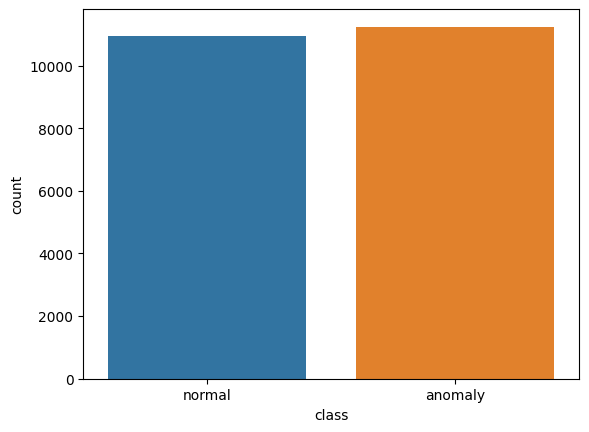

In [31]:
sns.countplot(x=train['class'])

### Label Encoding

In [32]:
def le(train):
    for col in train.columns:
        if train[col].dtype == 'object':
                label_encoder = LabelEncoder()
                train[col] = label_encoder.fit_transform(train[col])

le(train)
le(test)
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,18,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
2,0,1,44,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,21,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,21,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
5,0,1,44,1,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,0


### Feature selection

In [33]:
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

In [34]:
rfc = RandomForestClassifier()
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]
selected_features

['service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate']

In [35]:
X_train = X_train[selected_features]

### Split and scale data

In [36]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

### RandomForestClassifier

In [39]:
clf = RandomForestClassifier(n_estimators = 500, 
                             max_depth = 4, 
                             max_features = 3, 
                             bootstrap = True, 
                             random_state = 18).fit(x_train, y_train)

In [40]:
prediction = clf.predict(x_test)
acc = accuracy_score(y_test, prediction)
prec = precision_score(y_test, prediction)

In [41]:
print(f"Precision: {prec}")
print(f"Accuracy: {acc}")

Precision: 0.9753753753753753
Accuracy: 0.980015026296018
